In [1]:
import uproot # type: ignore
import pandas as pd # type: ignore
import numpy as np # type: ignore
import awkward as ak # type: ignore
import matplotlib # type: ignore
from mpl_toolkits.mplot3d import Axes3D # type: ignore
import matplotlib.pyplot as plt # type: ignore
import os
import math
import csv
import math
import seaborn as sns # type: ignore
import sympy as smp # type: ignore
import sympy.stats # type: ignore
from scipy import stats,signal,ndimage,special,fft # type: ignore
from scipy.optimize import curve_fit # type: ignore
from scipy.integrate import quad # type: ignore
from mpl_toolkits.axes_grid1 import make_axes_locatable # type: ignore

In [2]:
tracks = uproot.open("/nashome/z/zaemoore/2x2_CAF/2p2h_reco_output.root")
tracks["RecoTree"].show()
tracks["RecoTree"].keys()

branches = tracks["RecoTree"].arrays()[0]
file_index = branches['file_index']

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
reco_energy          | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_x             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_y             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_z             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_mag           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_length          | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_rot       | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_incl      | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_x         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_y         | std::

Functions and variables defined here

In [3]:
truth_protons = 0
reco_protons = 0
p_theta = []
candidate_files = []
p2 = []
hammer = 0
p_proton_truth_cont = []
p_proton_reco_cont = []
p_proton_truth_notcont = []
p_proton_reco_notcont = []
eventsperfile = []
truth_protons_file = []
reco_protons_file = []
truth_protons_ev_check = []

#Function to find angle between 2 (momentum) vectors
#Using dot product
def mag(x):
    return np.sqrt(np.sum(i ** 2 for i in x))

def theta(track1, track2):
    cos = np.dot(track1, track2) / (mag(track1) * mag(track2))
    cos = np.clip(cos, -1, 1)
    #p_theta = np.arccos(cos)
    return cos

def is_contained(x, y, z):
    tpc_dist = 8.0 #distance from the tpc wallsfor containment cuts
    xbound = 63.931
    ybound = 62.076
    zbound = 64.3163

    cont = False

    if abs(x) < xbound - tpc_dist and abs(y) < ybound - tpc_dist and abs(z) < zbound - tpc_dist:
        cont = True

    return cont

Loop through files and events

In [4]:
for file_idx in np.unique(file_index):
    totalevents = 0
    true_energy = branches['true_energy'][file_index == file_idx]
    true_p_x = branches['true_p_x'][file_index == file_idx]
    true_p_y = branches['true_p_y'][file_index == file_idx]
    true_p_z = branches['true_p_z'][file_index == file_idx]
    true_p_mag = branches['true_p_mag'][file_index == file_idx]
    true_length = branches['true_length'][file_index == file_idx]
    true_angle = branches['true_angle'][file_index == file_idx]
    true_angle_rot = branches['true_angle_rot'][file_index == file_idx]
    true_angle_incl = branches['true_angle_incl'][file_index == file_idx]
    true_angle_x = branches['true_angle_x'][file_index == file_idx]
    true_angle_y = branches['true_angle_y'][file_index == file_idx]
    true_angle_z = branches['true_angle_z'][file_index == file_idx]
    true_track_start_x = branches['true_track_start_x'][file_index == file_idx]
    true_track_start_y = branches['true_track_start_y'][file_index == file_idx]
    true_track_start_z = branches['true_track_start_z'][file_index == file_idx]
    true_track_end_x = branches['true_track_end_x'][file_index == file_idx]
    true_track_end_y = branches['true_track_end_y'][file_index == file_idx]
    true_track_end_z = branches['true_track_end_z'][file_index == file_idx]
    true_pdg = branches['true_pdg'][file_index == file_idx]
    true_nproton = branches['true_nproton'][file_index == file_idx]

    reco_pdg = branches['reco_pdg'][file_index == file_idx]
    reco_energy = branches['reco_energy'][file_index == file_idx]
    reco_p_x = branches['reco_p_x'][file_index == file_idx]
    reco_p_y = branches['reco_p_y'][file_index == file_idx]
    reco_p_z = branches['reco_p_z'][file_index == file_idx]
    reco_p_mag = branches['reco_p_mag'][file_index == file_idx]

    spill_index = branches['spill_index'][file_index == file_idx]
    event = branches['event'][file_index == file_idx]
    run = branches['run'][file_index == file_idx]
    subrun = branches['subrun'][file_index == file_idx]
    caf_file_name = branches['caf_file_name'][file_index == file_idx]

    #Loop through each event in the file
    for ev in np.unique(event):
        true_nproton_ev = true_nproton[event == ev]
        truth_protons = 0
        reco_protons = 0
        truth_protons_ev_check.append(true_nproton_ev)

        if true_nproton_ev[0] >= 2:
            totalevents += 1
            true_pdg_ev = true_pdg[event == ev]
            true_start_x_ev = true_track_start_x[event == ev]
            true_start_y_ev = true_track_start_y[event == ev]
            true_start_z_ev = true_track_start_z[event == ev]
            true_end_x_ev = true_track_end_x[event == ev]
            true_end_y_ev = true_track_end_y[event == ev]
            true_end_z_ev = true_track_end_z[event == ev]
            true_p_mag_ev = true_p_mag[event == ev]

            reco_pdg_ev = reco_pdg[event == ev]
            reco_energy_ev = reco_energy[event == ev]
            reco_p_x_ev = reco_p_x[event == ev]
            reco_p_y_ev = reco_p_y[event == ev]
            reco_p_z_ev = reco_p_z[event == ev]
            reco_p_mag_ev = reco_p_mag[event == ev]

            x_track = []
            y_track = []
            z_track = []
            p_mag = []

            #Loop through truth particles
            for i in range(len(true_start_z_ev)):
                if true_pdg_ev[i] == 2212 and true_p_mag_ev[i] >= .0: #Protons with a momentum higher than 250 MeV
                    x_track.append(true_end_x_ev[i] - true_start_x_ev[i])
                    y_track.append(true_end_y_ev[i] - true_start_y_ev[i])
                    z_track.append(true_end_z_ev[i] - true_start_z_ev[i])
                    p_mag.append(true_p_mag_ev[i])

                if true_pdg_ev[i] == 2212:
                    truth_protons+=1

                if true_pdg_ev[i] == 2212 and reco_pdg_ev[i] == 2212 and is_contained(true_end_x_ev[i], true_end_y_ev[i], true_end_z_ev[i]): #contained protons
                    p_proton_reco_cont.append(reco_p_mag_ev[i])
                    p_proton_truth_cont.append(true_p_mag_ev[i])

                if true_pdg_ev[i] == 2212 and reco_pdg_ev[i] == 2212 and is_contained(true_end_x_ev[i], true_end_y_ev[i], true_end_z_ev[i]) == False: #UNcontained protons
                    p_proton_reco_notcont.append(reco_p_mag_ev[i])
                    p_proton_truth_notcont.append(true_p_mag_ev[i])
                    
            #Loop through reco particles
            for i in range(len(reco_pdg_ev)):
                if reco_pdg_ev[i] == 2212:
                    reco_protons+=1

            reco_protons_file.append(reco_protons)
            truth_protons_file.append(truth_protons)

            #Compare angles for every combination of truth protons in events with >=2 protons
            for i in range(len(z_track) - 1):
                for j in range(i+1, len(z_track)):
                    track1 = [x_track[i], y_track[i], z_track[i]]
                    track2 = [x_track[j], y_track[j], z_track[j]]
                    angle = theta(track1, track2)
                    if angle <= -0.95:
                        candidate_files.append(file_idx)
                    p2.append(min(p_mag[i], p_mag[j])*1000)
                    p_theta.append(angle)

    eventsperfile.append(totalevents)

/tmp/ipykernel_1652878/2553222552.py:19: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sqrt(np.sum(i ** 2 for i in x))


Compare true and reco proton momentum

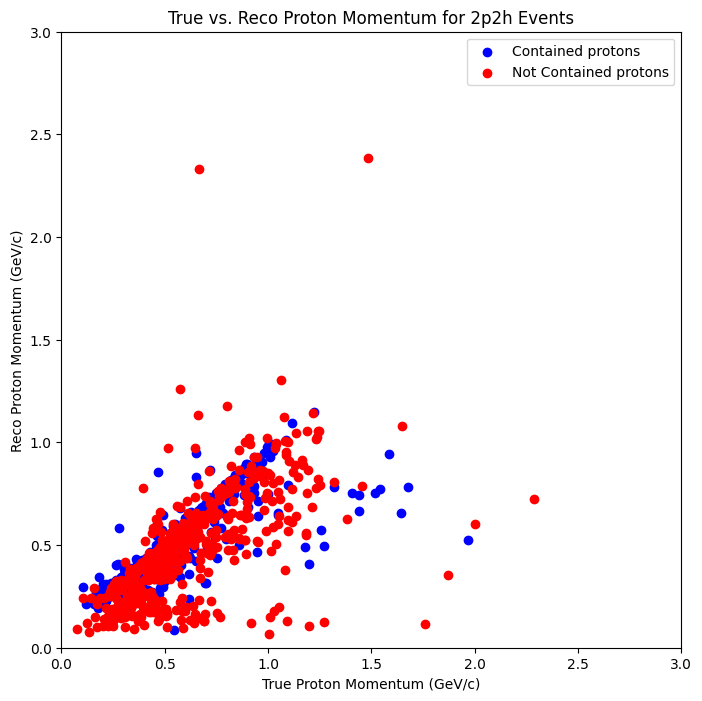

In [5]:
fig = plt.figure(figsize=(8,8))
plt.scatter(p_proton_truth_cont, p_proton_reco_cont, color = "blue", label="Contained protons")
plt.scatter(p_proton_truth_notcont, p_proton_reco_notcont, color = "red", label="Not Contained protons")
plt.xlabel("True Proton Momentum (GeV/c)")
plt.ylabel("Reco Proton Momentum (GeV/c)")
plt.ylim(0, 3)
plt.xlim(0, 3)
plt.title("True vs. Reco Proton Momentum for 2p2h Events")
plt.legend()
plt.show()

outlier = 0